### Create environment

(314, {'prob': 1.0, 'action_mask': array([1, 1, 0, 0, 0, 0], dtype=int8)})


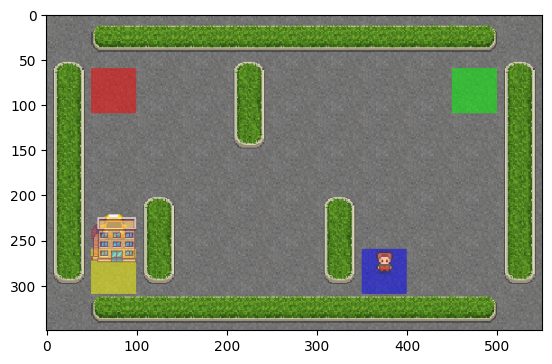

In [1]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

env = gym.make("Taxi-v3", render_mode="rgb_array")
print(env.reset(seed=0))
plt.imshow(env.render())


In [2]:
n_states = env.observation_space.n
n_actions = env.action_space.n

print(f"n_states={n_states}, n_actions={n_actions}")


n_states=500, n_actions=6


In [3]:
def initialize_policy(n_states, n_actions):
    return np.zeros((n_states, n_actions)) + 1. / n_actions


policy = initialize_policy(n_states, n_actions)


In [4]:
def generate_session(env, policy, t_max=10**4):
    """
    Play game until end or for t_max ticks.
    :param policy: an array of shape [n_states,n_actions] with action probabilities
    :returns: list of states, list of actions and sum of rewards
    """
    states, actions = [], []
    total_reward = 0.0

    s, _ = env.reset()

    for t in range(t_max):
        # Hint: you can use np.random.choice for sampling action
        # https://numpy.org/doc/stable/reference/random/generated/numpy.random.choice.html

        a = np.random.choice(n_actions, p=policy[s])

        new_s, r, terminated, truncated, _ = env.step(a)

        # Record information we just got from the environment.
        states.append(s)
        actions.append(a)
        total_reward += r

        s = new_s
        if terminated or truncated:
            break

    return states, actions, total_reward


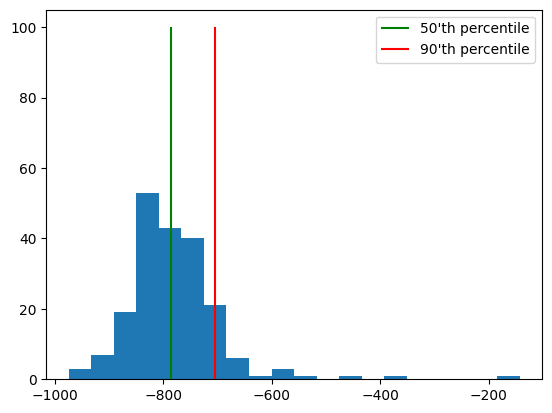

In [5]:
# let's see the initial reward distribution
import matplotlib.pyplot as plt
%matplotlib inline

sample_rewards = [generate_session(env, policy, t_max=1000)[-1] for _ in range(200)]

plt.hist(sample_rewards, bins=20)
plt.vlines([np.percentile(sample_rewards, 50)], [0], [100], label="50'th percentile", color='green')
plt.vlines([np.percentile(sample_rewards, 90)], [0], [100], label="90'th percentile", color='red')
plt.legend()

In [6]:
def select_elites(states_batch, actions_batch, rewards_batch, percentile):
    """
    Select states and actions from games that have rewards >= percentile
    :param states_batch: list of lists of states, states_batch[session_i][t]
    :param actions_batch: list of lists of actions, actions_batch[session_i][t]
    :param rewards_batch: list of rewards, rewards_batch[session_i]

    :returns: elite_states,elite_actions, both 1D lists of states and respective actions from elite sessions

    Please return elite states and actions in their original order
    [i.e. sorted by session number and timestep within session]

    If you are confused, see examples below. Please don't assume that states are integers
    (they will become different later).
    """

    reward_threshold = np.percentile(rewards_batch, percentile)

    elite_states = []
    elite_actions = []
    for i in range(len(rewards_batch)):
        if rewards_batch[i] >= reward_threshold:
            elite_states.extend(states_batch[i])
            elite_actions.extend(actions_batch[i])

    return elite_states, elite_actions


In [7]:
def get_new_policy(elite_states, elite_actions):
    """
    Given a list of elite states/actions from select_elites,
    return a new policy where each action probability is proportional to

        policy[s_i,a_i] ~ #[occurrences of s_i and a_i in elite states/actions]

    Don't forget to normalize the policy to get valid probabilities and handle the 0/0 case.
    For states that you never visited, use a uniform distribution (1/n_actions for all states).

    :param elite_states: 1D list of states from elite sessions
    :param elite_actions: 1D list of actions from elite sessions

    """

    new_policy = np.zeros([n_states, n_actions])

    for s, a in zip(elite_states, elite_actions):
        new_policy[s][a] += 1

        
    # Don't forget to set 1/n_actions for all actions in unvisited states.
    for i in range(n_states):
        if np.sum(new_policy[i]) == 0:
            new_policy[i] += 1 / n_actions
        else:
            new_policy[i] /= np.sum(new_policy[i])

    return new_policy


In [9]:
from IPython.display import clear_output


def show_progress(rewards_batch, log, percentile, reward_range=[-990, +10]):
    """
    A convenience function that displays training progress.
    No cool math here, just charts.
    """

    mean_reward = np.mean(rewards_batch)
    threshold = np.percentile(rewards_batch, percentile)
    log.append([mean_reward, threshold])

    plt.figure(figsize=[8, 4])
    plt.subplot(1, 2, 1)
    plt.plot(list(zip(*log))[0], label="Mean rewards")
    plt.plot(list(zip(*log))[1], label="Reward thresholds")
    plt.legend()
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.hist(rewards_batch, range=reward_range)
    plt.vlines(
        [np.percentile(rewards_batch, percentile)],
        [0],
        [100],
        label="percentile",
        color="red",
    )
    plt.legend()
    plt.grid()
    clear_output(True)
    print("mean reward = %.3f, threshold=%.3f" % (mean_reward, threshold))
    plt.show()


In [10]:
ITER_NUM = 100

### Let's explore n_sessions and rewards correlation

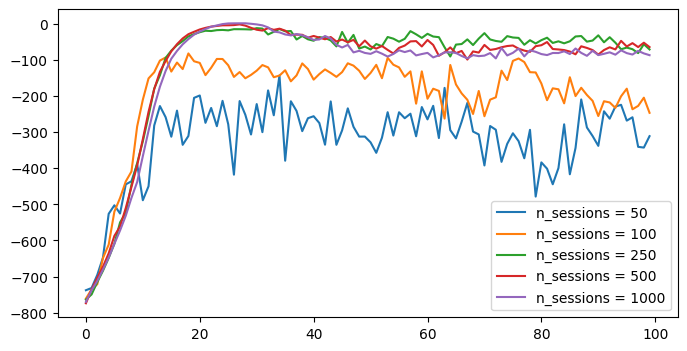

In [14]:
n_sessions = [50, 100, 250, 500, 1000]  # sample this many sessions
percentile = 50  # discard this percentage of sessions with lowest rewards
learning_rate = 0.5  # how quickly the policy is updated, on a scale from 0 to 1

log = []

for j in n_sessions:
    log.append([])
    policy = initialize_policy(n_states, n_actions)
    for i in range(ITER_NUM):
        sessions = [generate_session(env, policy) for _ in range(j)]

        states_batch, actions_batch, rewards_batch = zip(*sessions)

        elite_states, elite_actions = select_elites(states_batch, actions_batch, rewards_batch, percentile)

        new_policy = get_new_policy(elite_states, elite_actions)

        policy = learning_rate * new_policy + (1 - learning_rate) * policy

        log[-1].append(np.mean(rewards_batch))

        # display results on chart
        # show_progress(rewards_batch, log, percentile)

plt.figure(figsize=[8, 4])
for i in range(len(n_sessions)):
    plt.plot(log[i], label=f"n_sessions = {n_sessions[i]}")
plt.legend()
plt.show()

### Let's explore percentile and rewards correlation

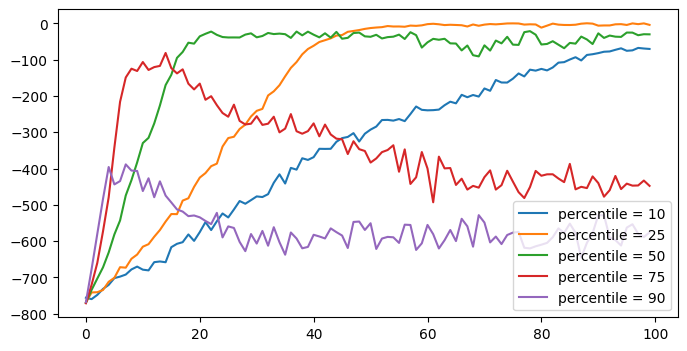

In [11]:
n_sessions = 250  # sample this many sessions
percentile = [10, 25, 50, 75, 90]  # discard this percentage of sessions with lowest rewards
learning_rate = 0.5  # how quickly the policy is updated, on a scale from 0 to 1

log = []

for j in percentile:
    log.append([])
    policy = initialize_policy(n_states, n_actions)
    for i in range(ITER_NUM):
        sessions = [generate_session(env, policy) for _ in range(n_sessions)]

        states_batch, actions_batch, rewards_batch = zip(*sessions)

        elite_states, elite_actions = select_elites(states_batch, actions_batch, rewards_batch, j)

        new_policy = get_new_policy(elite_states, elite_actions)

        policy = learning_rate * new_policy + (1 - learning_rate) * policy

        log[-1].append(np.mean(rewards_batch))

        # display results on chart
        # show_progress(rewards_batch, log, percentile)

plt.figure(figsize=[8, 4])
for i in range(len(percentile)):
    plt.plot(log[i], label=f"percentile = {percentile[i]}")
plt.legend()
plt.show()

### Best parameters: n_sessions = 250, percentile = 25, use it for training

mean reward = 1.620, threshold=0.000


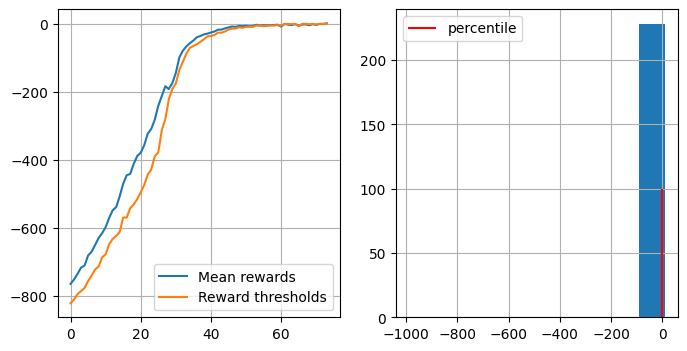

In [ ]:
n_sessions = 250
percentile = 25
learning_rate = 0.5

log = []

policy = initialize_policy(n_states, n_actions)

while True:
    sessions = [generate_session(env, policy) for _ in range(n_sessions)]

    states_batch, actions_batch, rewards_batch = zip(*sessions)

    elite_states, elite_actions = select_elites(states_batch, actions_batch, rewards_batch, percentile)

    new_policy = get_new_policy(elite_states, elite_actions)
    
    policy = learning_rate * new_policy + (1 - learning_rate) * policy

    # display results on chart
    show_progress(rewards_batch, log, percentile)

    if log[-1][0] > 0:
        break
